- Load necessary module

In [1]:
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
from scipy.stats import multinomial
from collections import OrderedDict

- Load model that defined in channel realization

In [2]:
np.random.seed(1)
mat = io.loadmat('temp.mat')
model = {}
model['H'] = mat['H']
# model['Wopt'] = mat['Wopt']
# model['Fopt'] = mat['Fopt']
# model['Ns'] = mat['Ns'][0,0] ## need to change nb of stream in channel realization, this case 1
model['Ns'] = 2
model['Nt'] = mat['Nt'][0,0]
model['Nr'] = mat['Nr'][0,0]
model['Nc'] = mat['Nc'][0,0]
model['Nray'] = mat['Nray'][0,0]
model['realization'] = mat['realization'][0,0]
model['At'] = mat['At']
model['Ar'] = mat['Ar']
model['Nrf'] = 2

In [3]:
for key in model:
    print(key)

H
Ns
Nt
Nr
Nc
Nray
realization
At
Ar
Nrf


Load values of phase shifter included:
- nb_bit: number of bit
- nb_ps: number of phase shifter in the system
- nb_state: number of state in each phase shifter (2^nb_bit)

# Cross Entropy Beamforming

### Helper function for Cross entropy Beamforming

In [4]:
def phase_shifter(n_bit,n_ant):
    """
    Define phase shifter with N bits resolution
    
    Arguments:
    N -- number of bits resolutions
    
    Returns:
    y -- python dictionnary of phase shifter: index of state and value of phase
    """
    nb_state = 2**n_bit
    w = np.exp(1j*2*np.pi/nb_state)
    ps = np.zeros(nb_state,dtype=complex)
    for i in range(nb_state):
        ps[i] = w**i/np.sqrt(n_ant)
    return np.around(ps, decimals=3)

def generate_candidat(S,model,phase_value,ps_system_proba):
    """
    generate S candidates from the previous pmf
    
    Arguments: 
    S -- Number of candidates to generate
    model -- channel model
    phase_value -- possible phase shifted value
    ps_system_proba -- pmf of phase shifters
    
    Returns
    F_rf -- S analog precoder system
    """
    F_rf = np.zeros((S,model['Nt'],model['Nrf']),dtype=complex)
    for i in range(S):
        for j in range(model['Nt']):
            for k in range(model['Nrf']):
                F_rf[i,j,k] = np.random.choice(phase_value, 1, p=ps_system_proba[j,k,:])
    return F_rf

def compute_Fbb(F_rf,model):
    """
    Compute baseband precoder base on the effective channel (Heq = H*Frf)
    
    Arguments:
    F_rf -- analog precoder
    model -- channel model
    
    Returns:
    F_bb -- S baseband precoder
    """
    S = F_rf.shape[0]
    channel_eq = np.zeros((S,model['Nr'],model['Nrf']),dtype=complex)
    F_bb = np.zeros((S,model['Nrf'],model['Ns']),dtype=complex)
    channel_index = 0 ### need to adjust 
    for i in range(S):
        channel_eq[i,:,:] =  model['H'][:,:,channel_index]@F_rf[i,:,:]
        U, s, V = np.linalg.svd(channel_eq[i,:,:], full_matrices=True)
        V = V.conj().T
        F_bb[i,:,:] = V[0:model['Nt'],0:model['Ns']]
        F_bb[i,:,:] = np.sqrt(model['Ns'])*F_bb[i,:,:]/np.linalg.norm(F_rf[i,:,:]@F_bb[i,:,:],'fro')
    return F_bb

def optimal_beamformer(model, channel_index):
    """
    Compute the optimal beamformer by SVD
    
    Arguments:
    model -- channel model
    channel_index -- index in 1000 realization channel
    
    Returns:
    Fopt -- optimal precoder
    Wopt -- optimal combiner
    """
    Wopt = np.zeros((model['Nr'],model['Ns']),dtype=complex)
    Fopt = np.zeros((model['Nt'],model['Ns']),dtype=complex)
    U, s, V = np.linalg.svd(model['H'][:,:,channel_index], full_matrices=True)
    V = V.conj().T
    Fopt = V[0:model['Nt'],0:model['Ns']]
    Wopt = U[0:model['Nr'],0:model['Ns']]
    return Fopt, Wopt


def update_pmf(F_elites,phase_value,nb_elite,R_elite):
    """
    Update new phase shifters's pmf base on previous candidates's results
    
    Arguments:
    F_elites -- elites analog precoder
    phase_value -- phase shift value
    nb_elite -- number of elites 
    
    Returns:
    ps_system_proba -- pmf of phase shifter
    """
    alpha = 0.9
    nb_state = phase_value.shape[0]
    stat_count = np.zeros(nb_state)
    assign = np.zeros(nb_elite)
    weight = R_elite/np.mean(R_elite)
    for i in range(model['Nt']):
        for j in range(model['Nrf']):
            for k in range(nb_state):
                assign = F_elites[:,i,j] == phase_value[k]
#                 proba_est = np.sum(assign*weight)/nb_elite
                proba_est = np.sum(assign)/nb_elite
                ps_system_proba[i,j,k] = alpha*proba_est + (1-alpha)*ps_system_proba[i,j,k] 
    return ps_system_proba

def data_rate(Ns,SNR,W,H,F):
    """
    Compute the data rate of the beamforming system
    
    Arguments:
    Ns -- number of stream
    SNR -- Signal to noise ratio
    W -- combiner
    H -- channel
    F -- precoder
    
    Returns:
    R -- data rate
    """
    R = np.log2(np.linalg.det(np.eye(Ns)+SNR/Ns*np.linalg.pinv(W)@H@F@F.conj().T@H.conj().T@W))
    return R.real

### Define Phase shiter

In [5]:
nb_bit = 2
nb_ps = model['Nt']*model['Nrf']
nb_ps
nb_state = 2**nb_bit

In [6]:
phase_value = phase_shifter(nb_bit,model['Nt'])
phase_value

array([ 0.125+0.   j,  0.   +0.125j, -0.125+0.   j, -0.   -0.125j])

Phase shifter system dimension is: NtxNrfxN_state

### Cross entropy beamforming Algorithm
 Step 1: Randomly generate S candidate analog beamformers

 Step 2: Compute S corresponding digital precoders Fbb based on the effective channel Heq = HFrf

 Step 3: Calculate the achievable sum-rate

 Step 4: Sort R in a descend order

 Step 5: Select elites as Frf_1, Frf_2, ..., Frf_elite

 Step 6: Update new pmf for each phase shifter

In [7]:
channel_index = 0
model['Fopt'], model['Wopt'] = optimal_beamformer(model,channel_index)


In [8]:
def CE_beamforming(nb_elite,S,nb_iterate,model,nb_bit,ps_system_proba,channel_index,SNR):
    """
    Hybrid beamforming by Cross-entropy method
    
    """
    Fopt, Wopt = model['Fopt'],model['Wopt']
    proba_evo = np.copy(ps_system_proba[0,0,:])
    print(proba_evo)
    relative_std = 1000 # initialize high value of relative standard deviation
    i = 0
    while ((i<nb_iterate) and (relative_std>3)):
        print(i)
        F_rf = generate_candidat(S,model,phase_value,ps_system_proba)
        F_bb = compute_Fbb(F_rf,model)
        R = np.zeros((S))
        for j in range(S):
            R[j] = data_rate(model['Ns'],SNR,Wopt,model['H'][:,:,channel_index],F_rf[j,:,:]@F_bb[j,:,:])
        R_sort_index = np.argsort(R)[::-1][:nb_elite]
        if i==0:
            R_max = R[R_sort_index[0]]
        else:
            R_max = np.append(R_max,R[R_sort_index[0]])
        F_elites = F_rf[R_sort_index,:,:]
        Frf_max = F_rf[R_sort_index[0],:,:]
        Fbb_max = F_bb[R_sort_index[0],:,:]
        ps_system_proba = update_pmf(F_elites,phase_value,nb_elite,R[R_sort_index])
        proba_evo = np.vstack((proba_evo,ps_system_proba[0,0,:]))
        if i>=5:
            R_max_normalize = R_max-np.min(R_max) ## Need to review
            relative_std = 100*np.std(R_max_normalize[i-5:i])/np.mean(R_max_normalize[i-5:i])
            print(relative_std)
        i +=1
    output = {}
    output['R_max'] = R_max
    output['Frf_max'] = Frf_max
    output['Fbb_max'] = Fbb_max
    output['nb_ite'] = i
    output['proba_evo'] = proba_evo
    output['ps_system_proba'] = ps_system_proba
    return output

In [9]:
nb_elite = 40
S = 200
channel_index = 0
nb_iterate = 30
ps_system_proba = np.ones((model['Nt'],model['Nrf'],nb_state))*(1/nb_state)
SNR = 10**(10/10)
CE_result = CE_beamforming(nb_elite,S,nb_iterate,model,nb_bit,ps_system_proba,channel_index,SNR)

[0.25 0.25 0.25 0.25]
0
1
2
3
4
5
69.51111768749425
6
69.12010865755478
7
68.41021967284416
8
69.99167303964771
9
62.02354234613916
10
42.70036570019753
11
26.33054090893619
12
19.434846767370548
13
18.967952059838886
14
15.233067724577202
15
11.486419995260896
16
8.466117199507183
17
6.095199054934541
18
4.674230664769908
19
3.9345235402627545
20
2.943796653605818


In [10]:
# Evolution of pmf of 1 phase shifter
np.around(CE_result['proba_evo'], decimals=3)

array([[0.25 , 0.25 , 0.25 , 0.25 ],
       [0.25 , 0.295, 0.34 , 0.115],
       [0.272, 0.232, 0.394, 0.102],
       [0.275, 0.248, 0.354, 0.123],
       [0.32 , 0.137, 0.328, 0.215],
       [0.167, 0.104, 0.393, 0.336],
       [0.107, 0.055, 0.534, 0.304],
       [0.101, 0.073, 0.481, 0.345],
       [0.078, 0.03 , 0.453, 0.44 ],
       [0.053, 0.003, 0.518, 0.426],
       [0.05 , 0.   , 0.412, 0.538],
       [0.028, 0.   , 0.401, 0.571],
       [0.003, 0.   , 0.355, 0.642],
       [0.   , 0.   , 0.373, 0.627],
       [0.   , 0.   , 0.307, 0.693],
       [0.   , 0.   , 0.256, 0.744],
       [0.   , 0.   , 0.206, 0.794],
       [0.   , 0.   , 0.178, 0.822],
       [0.   , 0.   , 0.108, 0.892],
       [0.   , 0.   , 0.101, 0.899],
       [0.   , 0.   , 0.168, 0.832],
       [0.   , 0.   , 0.152, 0.848]])

Data rate evolution: [12.73687325 12.33382457 12.60165619 13.09349123 12.66576877 13.05653077
 14.05766667 15.1056383  15.30098554 15.87300206 16.42346333 16.99484612
 17.47463937 17.80187263 18.02186134 18.31718634 18.42683248 18.55600899
 18.73406803 18.80856738 18.85566353]
Number of iteration: 21
Phase shifter pmf[[0.25  0.25  0.25  0.25 ]
 [0.25  0.295 0.34  0.115]
 [0.272 0.232 0.394 0.102]
 [0.275 0.248 0.354 0.123]
 [0.32  0.137 0.328 0.215]
 [0.167 0.104 0.393 0.336]
 [0.107 0.055 0.534 0.304]
 [0.101 0.073 0.481 0.345]
 [0.078 0.03  0.453 0.44 ]
 [0.053 0.003 0.518 0.426]
 [0.05  0.    0.412 0.538]
 [0.028 0.    0.401 0.571]
 [0.003 0.    0.355 0.642]
 [0.    0.    0.373 0.627]
 [0.    0.    0.307 0.693]
 [0.    0.    0.256 0.744]
 [0.    0.    0.206 0.794]
 [0.    0.    0.178 0.822]
 [0.    0.    0.108 0.892]
 [0.    0.    0.101 0.899]
 [0.    0.    0.168 0.832]
 [0.    0.    0.152 0.848]]


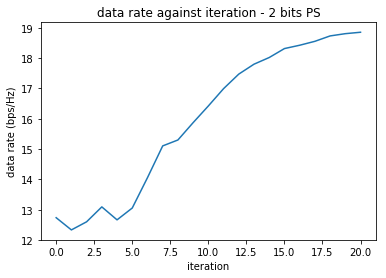

In [11]:
print('Data rate evolution: ' + str(CE_result['R_max']))
plt.plot(CE_result['R_max'])
plt.title('data rate against iteration - 2 bits PS')
plt.ylabel('data rate (bps/Hz)')
plt.xlabel('iteration')
print('Number of iteration: ' + str(CE_result['nb_ite']))
print('Phase shifter pmf' + str(np.around(CE_result['proba_evo'], decimals=3)))

Test:

2 bits -- 17.56 bps/Hz - 16 iterate

3 bits -- 17.68 bps/Hz - 18 iterate

4 bits -- 17.71 bps/Hz - 18 iterate

6 bits -- 17.68 bps/Hz - 19 iterate

# Digital Beamforming

In [12]:
R_o = data_rate(model['Ns'],SNR,model['Wopt'],model['H'][:,:,channel_index],model['Fopt'])
print('Data rate by digital beamforming: ' + str(R_o))

Data rate by digital beamforming: 20.41756613013491


In [13]:
# Normalize condition
x = np.linalg.norm(CE_result['Frf_max']@CE_result['Fbb_max'],'fro')
print("Ns", model['Ns'] , "   Frobenius norm FRF*FBB=", x**2)

Ns 2    Frobenius norm FRF*FBB= 2.0000000000000004


# OMP Beamforming

In [14]:
def OMP(_Fopt,_NRF,_At):
    """
    Orthogonal matching pursuit for hybrid beamforming
    
    """
    _FRF = np.empty((_At.shape[0],0))
    _Fres = _Fopt
    for k in range(_NRF):
        PU = _At.conj().T@_Fres
        ind = np.argmax(np.sum((np.absolute(PU))**2,axis=1))
        _FRF = np.append(_FRF,_At[:,[ind]],axis=1)
        _FBB = (np.linalg.pinv(_FRF))@_Fopt
        _Fres = (_Fopt-_FRF@_FBB)/np.linalg.norm((_Fopt-_FRF@_FBB),'fro')
#         _Fres = (_Fopt-_FRF@_FBB)
    return _FRF,_FBB

In [15]:
FRF_omp, FBB_omp = OMP( model['Fopt'], model['Nrf'], model['At'][:,:,channel_index] ) 

In [16]:
R_omp = data_rate(model['Ns'],SNR,model['Wopt'],model['H'][:,:,channel_index],FRF_omp@FBB_omp)
print("Data rate by OMP: " + str(R_omp))

Data rate by OMP: 16.7201107591366


### Quantize omp beamforming

In [17]:
def quantize_Frf(model,n_bit,F_rf,channel_index):
    """
    Quantize precoder for low resolutioin phase shifter
    
    """
    q = 2*np.pi/2**n_bit
    amplitude = 1/np.sqrt(model['Nt'])
    Frf_angle = np.angle(F_rf)
    angle_quantized = q * np.round(Frf_angle/q)
    Frf_quantized = amplitude*np.exp(1j*angle_quantized)
    Frf_quantized = np.around(Frf_quantized, decimals=3)
    
    channel_eq =  model['H'][:,:,channel_index]@Frf_quantized
    U, s, V = np.linalg.svd(channel_eq, full_matrices=True)
    V = V.conj().T
    F_bb = V[0:model['Nt'],0:model['Ns']]
    F_bb = np.sqrt(model['Ns'])*F_bb/np.linalg.norm(Frf_quantized@F_bb,'fro')
    
    return Frf_quantized, F_bb

In [18]:
Frf_quantize, Fbb_quantize = quantize_Frf(model,nb_bit,FRF_omp,channel_index)

In [19]:
R_omp_quantized = data_rate(model['Ns'],SNR,model['Wopt'],model['H'][:,:,channel_index],Frf_quantize@Fbb_quantize)
print('Data rate by OMP with quantization: ' + str(R_omp_quantized))

Data rate by OMP with quantization: 17.96717163142237


In [20]:
# Normalize condition
x = np.linalg.norm(Frf_quantize@Fbb_quantize,'fro')
print("Ns", model['Ns'] , "   Frobenius norm FRF*FBB=", x**2)

Ns 2    Frobenius norm FRF*FBB= 2.0000000000000004


### Initialize pmf of phase shiter with OMP

In [21]:
phase_value

array([ 0.125+0.   j,  0.   +0.125j, -0.125+0.   j, -0.   -0.125j])

In [22]:
Frf_quantize

array([[ 0.125+0.   j,  0.125+0.   j],
       [-0.125+0.   j, -0.125-0.   j],
       [ 0.125+0.   j,  0.   +0.125j],
       [-0.125+0.   j,  0.   -0.125j],
       [ 0.125+0.   j, -0.125+0.   j],
       [-0.125+0.   j,  0.125+0.   j],
       [ 0.125+0.   j,  0.   -0.125j],
       [-0.125+0.   j,  0.   +0.125j],
       [ 0.125+0.   j,  0.125+0.   j],
       [-0.125-0.   j, -0.125-0.   j],
       [ 0.125+0.   j,  0.   +0.125j],
       [-0.125-0.   j,  0.   -0.125j],
       [ 0.125+0.   j, -0.125+0.   j],
       [-0.125-0.   j,  0.125+0.   j],
       [ 0.125+0.   j, -0.125-0.   j],
       [-0.125-0.   j,  0.   +0.125j],
       [ 0.125+0.   j,  0.125+0.   j],
       [-0.125-0.   j, -0.125-0.   j],
       [ 0.125+0.   j,  0.   +0.125j],
       [-0.125-0.   j,  0.   -0.125j],
       [ 0.125+0.   j, -0.125+0.   j],
       [-0.125-0.   j,  0.125+0.   j],
       [ 0.125+0.   j, -0.125-0.   j],
       [-0.125-0.   j,  0.   +0.125j],
       [ 0.125+0.   j,  0.125+0.   j],
       [-0.125-0.   j, -0

In [23]:
def initialize_pmf_omp(model,nb_bit,Frf_omp_quantize,phase_value,ratio):
    """
    Initialize pmf of phase shifter with solution getting by OMP
    
    """
    low_proba = 1/(2**nb_bit-1+ratio)
    high_proba = ratio*low_proba
    proba_init = np.zeros((model['Nt'],model['Nrf'],2**nb_bit))
    for i in range(phase_value.shape[0]):
        assign = Frf_quantize == phase_value[i]
        proba_init[:,:,i] = assign*high_proba + np.invert(assign)*low_proba
    return proba_init

### Cross entropy method with initialization by quantized OMP

In [24]:
nb_elite = 40
S = 200
channel_index = 0
nb_iterate = 30
ps_system_proba_omp = initialize_pmf_omp(model,nb_bit,Frf_quantize,phase_value,3)
SNR = 10**(10/10)
CE_result_omp = CE_beamforming(nb_elite,S,nb_iterate,model,nb_bit,ps_system_proba_omp,channel_index,SNR)

[0.5        0.16666667 0.16666667 0.16666667]
0
1
2
3
4
5
76.19918783758867
6
50.73839783175737
7
31.356445808870667
8
22.51090794356925
9
15.764530659265539
10
10.559954462826976
11
7.394889933539191
12
6.051861381263081
13
5.460957157243813
14
2.9759156585704076


Data rate evolution: [15.24493296 15.55494699 16.36772146 16.96154783 17.34239547 17.86239019
 18.25325698 18.51923789 18.52911611 18.864484   18.93430248 19.03811105
 19.09904698 19.17854895 19.20855943]
Number of iteration: 15
Phase shifter pmf[[0.5   0.167 0.167 0.167]
 [0.54  0.18  0.15  0.13 ]
 [0.617 0.176 0.128 0.08 ]
 [0.737 0.108 0.058 0.098]
 [0.681 0.146 0.028 0.145]
 [0.721 0.15  0.025 0.104]
 [0.837 0.082 0.003 0.078]
 [0.961 0.008 0.    0.03 ]
 [0.996 0.001 0.    0.003]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]]


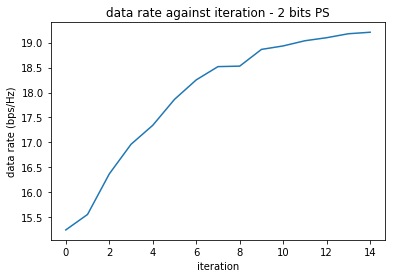

In [25]:
print('Data rate evolution: ' + str(CE_result_omp['R_max']))
plt.plot(CE_result_omp['R_max'])
plt.title('data rate against iteration - 2 bits PS')
plt.ylabel('data rate (bps/Hz)')
plt.xlabel('iteration')
print('Number of iteration: ' + str(CE_result_omp['nb_ite']))
print('Phase shifter pmf' + str(np.around(CE_result_omp['proba_evo'], decimals=3)))

In [26]:
# print(CE_result_omp['Frf_max'] == CE_result['Frf_max'])
# print(CE_result_omp['Frf_max'] == Frf_quantize)